# 03. PyTorch Computer Vision Exercise Solutions

The following is one possible set (there may be more than one way to do things) of solutions for the 03. PyTorch Computer Vision exercise template.

## Resources

1. These exercises/solutions are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA).
  * **Note:** Going through these exercises took me just over 3 hours, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [8]:
# Check for GPU
# !nvidia-smi

In [9]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

1.13.1


'cpu'

## 1. What are 3 areas in industry where computer vision is currently being used?

1. Self-driving cars, such as Tesla using computer vision to percieve what's happening on the road. See Tesla AI day for more - https://youtu.be/j0z4FweCy4M
2. Healthcare imaging, such as using computer vision to help interpret X-rays. Google also uses computer vision for detecting polyps in the intenstines - https://ai.googleblog.com/2021/08/improved-detection-of-elusive-polyps.html
3. Security, computer vision can be used to detect whether someone is invading your home or not - https://store.google.com/au/product/nest_cam_battery?hl=en-GB

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

Overfitting is like memorizing for a test, but then you can't answer a question that's slightly different.

In other words, if a model is overfitting, it's learning the training data *too well* and these patterns don't generalize to unseen data.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each.
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

See this article for some ideas: https://elitedatascience.com/overfitting-in-machine-learning

3 ways to prevent overfitting:
1. **Regularization techniques** - You could use [dropout on your neural networks](https://en.wikipedia.org/wiki/Dilution_(neural_networks)), dropout involves randomly removing neurons in different layers so that the remaining neurons hopefully learn more robust weights/patterns.
2. **Use a different model** - maybe the model you're using for a specific problem is too complicated, as in, it's learning the data too well because it has so many layers. You could remove some layers to simplify your model. Or you could pick a totally different model altogether, one that may be more suited to your particular problem. Or... you could also use [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) (taking the patterns from one model and applying them to your own problem).
3. **Reduce noise in data/cleanup dataset/introduce data augmentation techniques** - If the model is learning the data too well, it might be just memorizing the data, including the noise. One option would be to remove the noise/clean up the dataset or if this doesn't, you can introduce artificial noise through the use of data augmentation to artificially increase the diversity of your training dataset.

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

The CNN explainer website is a great insight into all the nuts and bolts of a convolutional neural network.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [10]:
import torchvision
import os
from torchvision import datasets, transforms

In [11]:
# Define the paths
check_path = './mnist/MNIST/raw'
download_path = '../mnist/'

# Check if MNIST dataset exists in the specified path
if not os.path.exists(check_path):
    print("MNIST dataset not found. Downloading to", download_path)
    transform = transforms.Compose([transforms.ToTensor()])

    # Download and load the MNIST train dataset
    train_data = datasets.MNIST(root=download_path,
                                train=True,
                                download=True,
                                transform=transform)

    # Download and load the MNIST test dataset
    test_data = datasets.MNIST(root=download_path,
                               train=False,
                               download=True,
                               transform=transform)
    print("MNIST dataset downloaded successfully.")
else:
    print("MNIST dataset found in", check_path)
    transform = transforms.Compose([transforms.ToTensor()])

    # Load the MNIST train dataset from the local path
    train_data = datasets.MNIST(root=download_path,
                                train=True,
                                download=False,
                                transform=transform)

    # Load the MNIST test dataset from the local path
    test_data = datasets.MNIST(root=download_path,
                               train=False,
                               download=False,
                               transform=transform)
    print("MNIST dataset loaded from", check_path)


MNIST dataset not found. Downloading to ../mnist/
MNIST dataset downloaded successfully.


In [12]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ../mnist/
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ../mnist/
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
            ))

In [13]:
len(train_data), len(test_data)

(60000, 10000)

In [14]:
# # Data is in tuple form (image, label)
# img = train_data[2][0]
# label = train_data[2][1]
# print(f"Image:\n {img}")
# print(f"Label:\n {label}")

In [15]:
# # Check out the shapes of our data
# print(f"Image shape: {img.shape} -> [color_channels, height, width] (CHW)")
# print(f"Label: {label} -> no shape, due to being integer")

Note: There are two main agreed upon ways for representing images in machine learning:
1. Color channels first: [color_channels, height, width] (CHW) -> PyTorch default (as of April 2022)
2. Color channels last: [height, width, color_channels] (HWC) -> Matplotlib/TensorFlow default (as of April 2022)

In [16]:
# Get the class names from the dataset
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## 6. Visualize at least 5 different samples of the MNIST training dataset.

In [17]:
import matplotlib.pyplot as plt

# for i in range(5):
#   img = train_data[i][0]
#   print(img.shape)
#   img_squeeze = img.squeeze()
#   print(img_squeeze.shape)
#   label = train_data[i][1]
#   plt.figure(figsize=(3, 3))
#   plt.imshow(img_squeeze, cmap="gray")
#   plt.title(label)
#   plt.axis(False)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [18]:
# Create train dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=16,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=16,
                             shuffle=False)

In [19]:
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1f289eb4e80>,
 <torch.utils.data.dataloader.DataLoader at 0x1f289eb4a00>)

In [20]:
for sample in next(iter(train_dataloader)):
  print(sample.shape)

torch.Size([16, 1, 28, 28])
torch.Size([16])


In [21]:
len(train_dataloader), len(test_dataloader)

(3750, 625)

## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [22]:
from torch import nn
class MNISTModel(torch.nn.Module):
  """Model capable of predicting on MNIST dataset.
  """
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units*7*7,
                out_features=output_shape)
    )

  def forward(self, x):
    """

    :param x:
    :return:
    """
    x = self.conv_block_1(x)
    print(f"Output shape of conv block 1: {x.shape}")
    x = self.conv_block_2(x)
    print(f"Output shape of conv block 2: {x.shape}")
    # Before applying classifier, just flatten and print the shape
    x_flattened = nn.Flatten()(x) # Flatten the tensor
    self.get_flatten = nn.Flatten()(x) # flatten and save to a class attribute
    print(f"Shape after flattening: {x_flattened.shape}")
    x = self.classifier(x)
    print(f"Output shape of classifier: {x.shape}")
    return x

In [23]:
device

'cpu'

In [24]:
model = MNISTModel(input_shape=1,
                    hidden_units=10,
                    output_shape=10).to(device)
model

MNISTModel(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [25]:
# Create a random input tensor with the shape that matches a single MNIST image (1, 28, 28)
# Note: The first 1 is the batch size, indicating we're feeding 1 image.
my_input_tensor = torch.randn(1, 1, 28, 28).to(device)
print(my_input_tensor.shape)

# Pass the input tensor through the model to print the output shapes of each block
my_output = model(my_input_tensor)
my_output

torch.Size([1, 1, 28, 28])
Output shape of conv block 1: torch.Size([1, 10, 14, 14])
Output shape of conv block 2: torch.Size([1, 10, 7, 7])
Shape after flattening: torch.Size([1, 490])
Output shape of classifier: torch.Size([1, 10])


tensor([[ 0.0652,  0.0610,  0.0084,  0.0237,  0.0569,  0.0073, -0.0203,  0.0536,
         -0.0457,  0.0524]], grad_fn=<AddmmBackward0>)

In [26]:
# # Check out the model state dict to find out what patterns our model wants to learn
# model.state_dict()

In [27]:
weights = model.classifier[1].weight.data
bias = model.classifier[1].bias.data

print(weights)
print(bias)

tensor([[ 0.0005,  0.0311, -0.0373,  ..., -0.0305,  0.0435,  0.0088],
        [ 0.0130, -0.0297, -0.0048,  ..., -0.0058,  0.0298, -0.0225],
        [-0.0370, -0.0186,  0.0123,  ..., -0.0108, -0.0202,  0.0205],
        ...,
        [-0.0383, -0.0093, -0.0360,  ...,  0.0038,  0.0226,  0.0414],
        [ 0.0152,  0.0092, -0.0115,  ...,  0.0329, -0.0309,  0.0213],
        [-0.0142, -0.0202,  0.0115,  ...,  0.0010,  0.0197, -0.0254]])
tensor([ 0.0437,  0.0239,  0.0010,  0.0361,  0.0418,  0.0030, -0.0161,  0.0286,
        -0.0320, -0.0151])


In [28]:
# Try a dummy forward pass to see what shapes our data is
dummy_x = torch.rand(size=(1, 28, 28)).unsqueeze(dim=0).to(device)

print(dummy_x.shape)
model(dummy_x)
# dummy_x

torch.Size([1, 1, 28, 28])
Output shape of conv block 1: torch.Size([1, 10, 14, 14])
Output shape of conv block 2: torch.Size([1, 10, 7, 7])
Shape after flattening: torch.Size([1, 490])
Output shape of classifier: torch.Size([1, 10])


tensor([[ 0.0586,  0.0520, -0.0012,  0.0395,  0.0515,  0.0053, -0.0325,  0.0438,
         -0.0488,  0.0448]], grad_fn=<AddmmBackward0>)

In [29]:
dummy_x_2 = torch.rand(size=([1, 10, 7, 7]))
dummy_x_2.shape

torch.Size([1, 10, 7, 7])

In [30]:
flatten_layer = nn.Flatten()
flatten_layer(dummy_x_2).shape

torch.Size([1, 490])

## 9. Train the model you built in exercise 8 for 5 epochs on CPU and GPU and see how long it takes on each.

In [31]:
# %%time
# from tqdm.auto import tqdm
#
# # Train on CPU
# model_cpu = MNISTModel(input_shape=1,
#                         hidden_units=10,
#                         output_shape=10).to("cpu")
#
# # Create a loss function and optimizer
# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model_cpu.parameters(), lr=0.1)
#
# ### Training loop
# epochs = 5
# for epoch in tqdm(range(epochs)):
#   train_loss = 0
#   for batch, (X, y) in enumerate(train_dataloader):
#     model_cpu.train()
#
#     # Put data on CPU
#     X, y = X.to("cpu"), y.to("cpu")
#
#     # Forward pass
#     y_pred = model_cpu(X)
#
#     # Loss calculation
#     loss = loss_fn(y_pred, y)
#     train_loss += loss
#
#     # Optimizer zero grad
#     optimizer.zero_grad()
#
#     # Loss backward
#     loss.backward()
#
#     # Step the optimizer
#     optimizer.step()
#
#   # Adjust train loss for number of batches
#   train_loss /= len(train_dataloader)
#
#   ### Testing loop
#   test_loss_total = 0
#
#   # Put model in eval mode
#   model_cpu.eval()
#
#   # Turn on inference mode
#   with torch.inference_mode():
#     for batch, (X_test, y_test) in enumerate(test_dataloader):
#       # Make sure test data on CPU
#       X_test, y_test = X_test.to("cpu"), y_test.to("cpu")
#       test_pred = model_cpu(X_test)
#       test_loss = loss_fn(test_pred, y_test)
#
#       test_loss_total += test_loss
#
#     test_loss_total /= len(test_dataloader)
#
#   # Print out what's happening
#   print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test loss: {test_loss_total:.3f}")

In [32]:
%%time
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Train on GPU
model_gpu = MNISTModel(input_shape=1,
                        hidden_units=10,
                        output_shape=10).to(device)

# Create a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_gpu.parameters(), lr=0.1)

# Training loop
epochs = 2
for epoch in tqdm(range(epochs)):
  train_loss = 0
  model_gpu.train()
  for batch, (X, y) in enumerate(train_dataloader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # Forward pass
    y_pred = model_gpu(X)

    # Loss calculation
    loss = loss_fn(y_pred, y)
    train_loss += loss

    # Optimizer zero grad
    optimizer.zero_grad()

    # Loss backward
    loss.backward()

    # Step the optimizer
    optimizer.step()

  # Adjust train loss to number of batches
  train_loss /= len(train_dataloader)

  ### Testing loop
  test_loss_total = 0
  # Put model in eval mode and turn on inference mode
  model_gpu.eval()
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(test_dataloader):
      # Make sure test data on target device
      X_test, y_test = X_test.to(device), y_test.to(device)

      test_pred = model_gpu(X_test)
      test_loss = loss_fn(test_pred, y_test)

      test_loss_total += test_loss

    # Adjust test loss total for number of batches
    test_loss_total /= len(test_dataloader)

  # Print out what's happening
  print(f"Epoch: {epoch} | Loss: {train_loss:.3f} | Test loss: {test_loss_total:.3f}")

  0%|          | 0/2 [00:00<?, ?it/s]

Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 

 50%|█████     | 1/2 [00:18<00:18, 18.48s/it]

Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 

100%|██████████| 2/2 [00:38<00:00, 19.03s/it]

Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

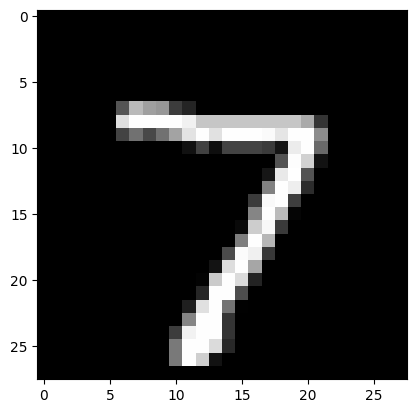

In [33]:
# Make predictions with the trained model
plt.imshow(test_data[0][0].squeeze(), cmap="gray")

In [34]:
# Logits -> Prediction probabilities -> Prediction labels
old_model_pred_logits = model_gpu(test_data[0][0].unsqueeze(dim=0).to(device)) # make sure image is right shape + on right device
old_model_pred_probs = torch.softmax(old_model_pred_logits, dim=1)
old_model_pred_label = torch.argmax(old_model_pred_probs, dim=1)
old_model_pred_label

Output shape of conv block 1: torch.Size([1, 10, 14, 14])
Output shape of conv block 2: torch.Size([1, 10, 7, 7])
Shape after flattening: torch.Size([1, 490])
Output shape of classifier: torch.Size([1, 10])


tensor([7])

In [35]:
num_to_plot = 5
for i in range(num_to_plot):
  # Get image and labels from the test data
  img = test_data[i][0]
  label = test_data[i][1]

  # Make prediction on image
  old_model_pred_logits = model_gpu(img.unsqueeze(dim=0).to(device))
  old_model_pred_probs = torch.softmax(old_model_pred_logits, dim=1)
  old_model_pred_label = torch.argmax(old_model_pred_probs, dim=1)
# 
#   # Plot the image and prediction
#   plt.figure()
#   plt.imshow(img.squeeze(), cmap="gray")
#   plt.title(f"Truth: {label} | Pred: {model_pred_label.cpu().item()}")
#   plt.axis(False)

Output shape of conv block 1: torch.Size([1, 10, 14, 14])
Output shape of conv block 2: torch.Size([1, 10, 7, 7])
Shape after flattening: torch.Size([1, 490])
Output shape of classifier: torch.Size([1, 10])
Output shape of conv block 1: torch.Size([1, 10, 14, 14])
Output shape of conv block 2: torch.Size([1, 10, 7, 7])
Shape after flattening: torch.Size([1, 490])
Output shape of classifier: torch.Size([1, 10])
Output shape of conv block 1: torch.Size([1, 10, 14, 14])
Output shape of conv block 2: torch.Size([1, 10, 7, 7])
Shape after flattening: torch.Size([1, 490])
Output shape of classifier: torch.Size([1, 10])
Output shape of conv block 1: torch.Size([1, 10, 14, 14])
Output shape of conv block 2: torch.Size([1, 10, 7, 7])
Shape after flattening: torch.Size([1, 490])
Output shape of classifier: torch.Size([1, 10])
Output shape of conv block 1: torch.Size([1, 10, 14, 14])
Output shape of conv block 2: torch.Size([1, 10, 7, 7])
Shape after flattening: torch.Size([1, 490])
Output shape 

In [36]:
# from google.colab import drive

# drive.mount("/content/drive")

# drive_path = "/content/drive/My Drive/Colab Notebooks/mnist"
# drive_path = r"D:\GitHub\transition-matrix-ml\notebooks"
drive_path = "C:/Courses/transition-matrix-ml/mnist"

In [37]:
import numpy as np

def generate_sample_dataset(input_dataset):
    """
    This function creates a new dataset subset with the
    specified number of samples.
    :param input_dataset: Original training dataset
    :return: Subset of the training dataset
            and a list of unique IDs (indices from the original dataset)
    """

    # Parameters
    n_samples = 1000

    generate_sample_labels = input_dataset.targets.numpy()

    # Determine the proportion of each class in the training dataset
    _, counts = np.unique(generate_sample_labels, return_counts=True)
    proportions = counts / len(generate_sample_labels)

    # Determine the number of samples to extract for each class
    samples_per_class = (proportions * n_samples).astype(int)

    # Adjust samples for any rounding issues to ensure exactly 1000 samples
    while np.sum(samples_per_class) < n_samples:
        class_with_max_samples = np.argmax(proportions)
        samples_per_class[class_with_max_samples] += 1
    
    # Extract samples based on the proportions
    indices_to_extract = []

    for gs_label, n_samples in enumerate(samples_per_class):
        label_indices = np.where(generate_sample_labels == gs_label)[0]
        chosen_indices = np.random.choice(label_indices, n_samples, replace=False)
        indices_to_extract.extend(chosen_indices)

    # Shuffle the indices for randomness
    np.random.shuffle(indices_to_extract)

    # Return a subset of the dataset
    sample_dataset = torch.utils.data.Subset(train_data, indices_to_extract)

    return sample_dataset, indices_to_extract


In [38]:
my_sample_dataset, my_indices = generate_sample_dataset(train_data)

In [39]:
import csv

n_pixels = 784

# Save the images and labels to a CSV file in Google Drive
with open(f"{drive_path}/mnist_matrix_B.csv", "w", newline="") as csvfile:
    csv_writer = csv.writer(csvfile)

    # Header
    header = ["unique_id", "label"] + ["pixel" + str(i) for i in range(n_pixels)]
    csv_writer.writerow(header)

    # Rows
    for sample_idx, (sample_image, sample_label) in zip(my_indices, my_sample_dataset):
        sample_image = sample_image[0].numpy().flatten()  # Extract the tensor from the tuple
        row = [sample_idx, sample_label] + sample_image.tolist()
        csv_writer.writerow(row)


In [40]:
def generate_prediction_weights(input_dataset):
    """
    This function extracts the weights from the model in the prediction stage
    :param input_dataset:
    :return:
    """
    total_images = len(input_dataset)

    my_pred_flattened = []
    my_pred_logits = []
    my_label_preds = []
    my_label_real = []

    for item in range(total_images):
        # Get image and labels from the test data
        input_image = input_dataset[item][0]
        input_label = input_dataset[item][1]
        my_label_real.append(input_label)

        # Extract and save the weights after the nn.Flatten() layer
        model_pred_flattened = model.get_flatten
        my_pred_flattened.append(model_pred_flattened)

        # Save the prediction weights
        model_pred_logits = model_gpu(input_image.unsqueeze(dim=0).to(device))
        my_pred_logits.append(model_pred_logits)

        # Save the prediction labels
        model_pred_labels = torch.argmax(torch.softmax(model_pred_logits, dim=1), dim=1)
        my_label_preds.append(model_pred_labels)

    my_pred_flattened = torch.cat(my_pred_flattened).cpu()
    my_pred_logits = torch.cat(my_pred_logits).cpu()
    my_label_preds = torch.cat(my_label_preds).cpu()

    return my_pred_flattened, my_pred_logits, my_label_preds, my_label_real


In [41]:
my_prediction_weights = generate_prediction_weights(my_sample_dataset)

Output shape of conv block 1: torch.Size([1, 10, 14, 14])
Output shape of conv block 2: torch.Size([1, 10, 7, 7])
Shape after flattening: torch.Size([1, 490])
Output shape of classifier: torch.Size([1, 10])
Output shape of conv block 1: torch.Size([1, 10, 14, 14])
Output shape of conv block 2: torch.Size([1, 10, 7, 7])
Shape after flattening: torch.Size([1, 490])
Output shape of classifier: torch.Size([1, 10])
Output shape of conv block 1: torch.Size([1, 10, 14, 14])
Output shape of conv block 2: torch.Size([1, 10, 7, 7])
Shape after flattening: torch.Size([1, 490])
Output shape of classifier: torch.Size([1, 10])
Output shape of conv block 1: torch.Size([1, 10, 14, 14])
Output shape of conv block 2: torch.Size([1, 10, 7, 7])
Shape after flattening: torch.Size([1, 490])
Output shape of classifier: torch.Size([1, 10])
Output shape of conv block 1: torch.Size([1, 10, 14, 14])
Output shape of conv block 2: torch.Size([1, 10, 7, 7])
Shape after flattening: torch.Size([1, 490])
Output shape 

In [42]:
import pandas as pd

def tensor_to_dataframe(tensor):
    """Convert a PyTorch tensor to a pandas DataFrame."""
    return pd.DataFrame(tensor.cpu().detach().numpy())

# Convert the tensor to a DataFrame
df_flattened = tensor_to_dataframe(my_prediction_weights[0])
df_logits = tensor_to_dataframe(my_prediction_weights[1])
df_preds = tensor_to_dataframe(my_prediction_weights[2])
df_labels = pd.DataFrame(my_prediction_weights[3])


In [43]:
# Convert indices to a DataFrame
df_indices = pd.DataFrame(my_indices, columns=["unique_id"])

# Concatenate indices with other DataFrames
df_flattened = pd.concat([df_indices, df_flattened], axis=1)
df_logits = pd.concat([df_indices, df_logits], axis=1)
df_preds = pd.concat([df_indices, df_preds], axis=1)
df_labels = pd.concat([df_indices, df_labels], axis=1)


In [44]:
# Save the DataFrame to a CSV file
with open(f"{drive_path}/mnist_matrix_A.csv", "w", newline="") as file_flattened:
    df_flattened.to_csv(file_flattened)
with open(f"{drive_path}/mnist_logits.csv", "w", newline="") as file_logits:
    df_logits.to_csv(file_logits)
with open(f"{drive_path}/mnist_preds.csv", "w", newline="") as file_preds:
    df_preds.to_csv(file_preds)
with open(f"{drive_path}/mnist_labels.csv", "w", newline="") as file_labels:
    df_labels.to_csv(file_labels)

In [45]:
# This code is to delete the first column
# from the defined CSV file

# Read the CSV file into a pandas DataFrame
url = "https://raw.githubusercontent.com/radiukpavlo/transition-matrix-ml/main/mnist/mnist_matrix_A.csv"
df_flattened_new = pd.read_csv(url)

# Drop the first column
df_flattened_new = df_flattened_new.drop(df_flattened_new.columns[0], axis=1)

# Save the modified DataFrame to a new CSV file (if needed)
df_flattened_new.to_csv(f"{drive_path}/df_flattened_new.csv", index=False)


## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [46]:
# # See if torchmetrics exists, if not, install it
# try:
#     import torchmetrics, mldxtend
#     print(f"mlxtend version: {mlxtend.__version__}")
#     assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version should be 0.19.0 or higher"
# except:
#     !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
#     import torchmetrics, mlxtend
#     print(f"mlxtend version: {mlxtend.__version__}")

In [47]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be versioned 0.19.0 or higher

0.22.0


In [48]:
# Make predictions across all test data
from tqdm.auto import tqdm
model_gpu.eval()
y_preds = []
with torch.inference_mode():
    for batch, (X, y) in tqdm(enumerate(test_dataloader)):
        # Make sure data on right device
        X, y = X.to(device), y.to(device)
        # Forward pass
        y_pred_logits = model_gpu(X)
        # Logits -> Pred probs -> Pred label
        y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
        # Append the labels to the preds list
        y_preds.append(y_pred_labels)
    y_preds = torch.cat(y_preds).cpu()
len(y_preds)
print(y_preds)

33it [00:00, 321.25it/s]

Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 

151it [00:00, 384.43it/s]

Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 

230it [00:00, 387.07it/s]

Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 

311it [00:00, 393.59it/s]

Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 

355it [00:00, 404.54it/s]

Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 

439it [00:01, 408.01it/s]

Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Outp

524it [00:01, 399.61it/s]

Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 

625it [00:01, 392.99it/s]

Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 490])
Output shape of classifier: torch.Size([16, 10])
Output shape of conv block 1: torch.Size([16, 10, 14, 14])
Output shape of conv block 2: torch.Size([16, 10, 7, 7])
Shape after flattening: torch.Size([16, 

In [49]:
test_data.targets[:10], y_preds[:10]

(tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]),
 tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9]))

C:\Users\radiu\anaconda3\envs\courses\lib\site-packages\torchaudio\backend\utils.py:62: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


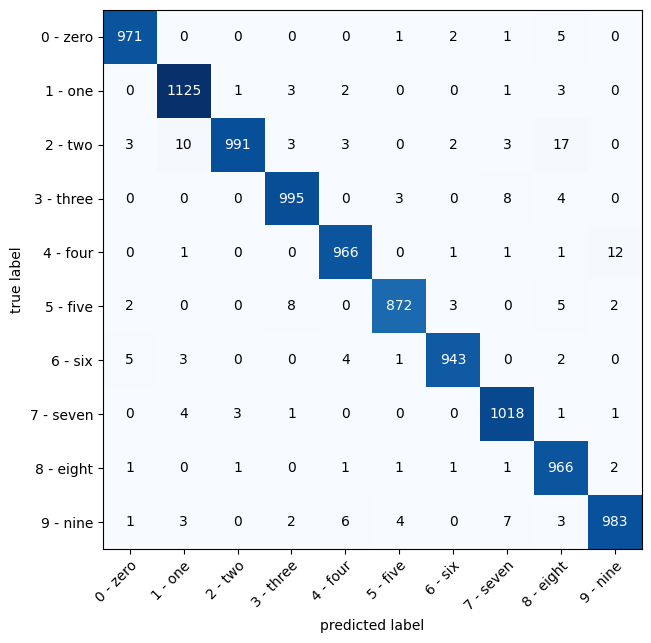

In [50]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_preds,
                         target=test_data.targets)

# Plot the confusion matrix
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

random_tensor = torch.rand([1, 3, 64, 64])
random_tensor.shape

conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=64,
                       kernel_size=3,
                       stride=2,
                       padding=1)

print(f"Random tensor original shape: {random_tensor.shape}")
random_tensor_through_conv_layer = conv_layer(random_tensor)
print(f"Random tensor through conv layer shape: {random_tensor_through_conv_layer.shape}")

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

# Download FashionMNIST train & test
from torchvision import datasets
from torchvision import transforms

fashion_mnist_train = datasets.FashionMNIST(root=".",
                                            download=True,
                                            train=True,
                                            transform=transforms.ToTensor())

fashion_mnist_test = datasets.FashionMNIST(root=".",
                                           train=False,
                                           download=True,
                                           transform=transforms.ToTensor())

len(fashion_mnist_train), len(fashion_mnist_test)

# Get the class names of the Fashion MNIST dataset
fashion_mnist_class_names = fashion_mnist_train.classes
fashion_mnist_class_names

# Turn FashionMNIST datasets into dataloaders
from torch.utils.data import DataLoader

fashion_mnist_train_dataloader = DataLoader(fashion_mnist_train,
                                            batch_size=16,
                                            shuffle=True)

fashion_mnist_test_dataloader = DataLoader(fashion_mnist_test,
                                           batch_size=16,
                                           shuffle=False)

len(fashion_mnist_train_dataloader), len(fashion_mnist_test_dataloader)

# model_2 is the same architecture as MNISTModel
model_2 = MNISTModel(input_shape=1,
                      hidden_units=10,
                      output_shape=10).to(device)
model_2

# Setup loss and optimizer
from torch import nn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01)

# Setup metrics
from tqdm.auto import tqdm
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=len(fashion_mnist_class_names)).to(device)

# Setup training/testing loop
epochs = 2
for epoch in tqdm(range(epochs)):
  train_loss, test_loss_total = 0, 0
  train_acc, test_acc = 0, 0

  ### Training
  model_2.train()
  for batch, (X_train, y_train) in enumerate(fashion_mnist_train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)

    # Forward pass and loss
    y_pred = model_2(X_train)
    loss = loss_fn(y_pred, y_train)
    train_loss += loss
    train_acc += acc_fn(y_pred, y_train)

    # Backprop and gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Adjust the loss/acc (find the loss/acc per epoch)
  train_loss /= len(fashion_mnist_train_dataloader)
  train_acc /= len(fashion_mnist_train_dataloader)

  ### Testing
  model_2.eval()
  with torch.inference_mode():
    for batch, (X_test, y_test) in enumerate(fashion_mnist_test_dataloader):
      X_test, y_test = X_test.to(device), y_test.to(device)

      # Forward pass and loss
      y_pred_test = model_2(X_test)
      test_loss = loss_fn(y_pred_test, y_test)
      test_loss_total += test_loss

      test_acc += acc_fn(y_pred_test, y_test)
  
    # Adjust the loss/acc (find the loss/acc per epoch)
    test_loss /= len(fashion_mnist_test_dataloader)
    test_acc /= len(fashion_mnist_test_dataloader)
    
  # Print out what's happening
  print(f"Epoch: {epoch} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.2f} | Test loss: {test_loss_total:.3f} | Test acc: {test_acc:.2f}")

# Make predictions with trained model_2
test_preds = []
model_2.eval()
with torch.inference_mode():
  for X_test, y_test in tqdm(fashion_mnist_test_dataloader):
    y_logits = model_2(X_test.to(device))
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred_labels = torch.argmax(y_pred_probs, dim=1)
    test_preds.append(y_pred_labels)
test_preds = torch.cat(test_preds).cpu() # matplotlib likes CPU
test_preds[:10], len(test_preds)    

# Get wrong prediction indexes
import numpy as np
wrong_pred_indexes = np.where(test_preds != fashion_mnist_test.targets)[0]
len(wrong_pred_indexes)

# Select random 9 wrong predictions and plot them
import random
random_selection = random.sample(list(wrong_pred_indexes), k=9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_selection):
  # Get true and pred labels
  true_label = fashion_mnist_class_names[fashion_mnist_test[idx][1]]
  pred_label = fashion_mnist_class_names[test_preds[idx]]

  # Plot the wrong prediction with its original label
  plt.subplot(3, 3, i+1)
  plt.imshow(fashion_mnist_test[idx][0].squeeze(), cmap="gray")
  plt.title(f"True: {true_label} | Pred: {pred_label}", c="r")
  plt.axis(False)

From the look of some of these predictions, the model is getting about as confused as I would...

For example it predicts "Sneaker" instead of "Sandal" when it could have easily been a "Sneaker".

The same goes for the confusion between the classes of "T-shirt/top" and "Shirt", many of the examples here look similar.